### Data preprocessing ###
To run scDIFF, the first step is to create an AnnData object from the raw data.

The h5ad file should contain cells as obs and peaks as var. Within the 'var' category, at least three columns - 'chr', 'start', and 'end' - are required to denote the genomic region of each peak.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import scanpy as sc
import pandas as pd
import numpy as np

#### load data

In [2]:
adata = sc.read_h5ad("./data/Cortex/MosP1_MouseBrain(10x).h5ad")
print(np.unique(adata.obs["Batch"]))

['MosP1' 'MouseBrain(10x)']


### Run CACNN

In [3]:
%cd scDIFF/CACNN

/home/daozhang/scDIFF/scDIFF/CACNN


In [9]:
!python train.py -i "../../data/Cortex/MosP1_MouseBrain(10x).h5ad" \
            -g mm10 \
            -o "../../output/MosP1_MouseBrain(10x)" \
            --tissue Cortex \
            --bw_list H3k4me1_mm10.bigWig H3k4me3_mm10.bigWig H3k27ac_mm10.bigWig \
            --epifeature_dim 3 \
            --use_reg_cell \
            --alpha 10e-5

INFO(20250528 10:30:07) [train.py:116]:
##time: Wed May 28 10:30:07 2025
##cwd: /home/daozhang/scDIFF/scDIFF/CACNN
##cmd: train.py -i ../../data/Cortex/MosP1_MouseBrain(10x).h5ad -g mm10 -o ../../output/MosP1_MouseBrain(10x) --tissue Cortex --bw_list H3k4me1_mm10.bigWig H3k4me3_mm10.bigWig H3k27ac_mm10.bigWig --epifeature_dim 3 --use_reg_cell --alpha 10e-5
##args: Namespace(data='../../data/Cortex/MosP1_MouseBrain(10x).h5ad', z=64, g='mm10', lr=0.01, batch_size=128, num_workers=12, seq_len=1344, outdir='../../output/MosP1_MouseBrain(10x)', w=False, seed=2020, max_epoch=300, device=0, use_reg_cell=True, alpha=0.0001, epifeature_dim=3, root_path='../../data/', tissue='Cortex', bw_list=['H3k4me1_mm10.bigWig', 'H3k4me3_mm10.bigWig', 'H3k27ac_mm10.bigWig'])
Calculating AP: 100%|██████████████████████| 2000/2000 [00:05<00:00, 338.41it/s]
Epoch 100/300: 100%|█| 757/757 [00:28<00:00, 26.81it/s, loss/lr=0.1881/4.305e-03
Calculating AP: 100%|██████████████████████| 2000/2000 [00:05<00:00, 354.45

### Run DIFFormer

In [10]:
%cd ../DIFFormer

/home/daozhang/scDIFF/scDIFF/DIFFormer


In [11]:
!python train.py --data_dir "../../output/MosP1_MouseBrain(10x)/CACNN_output.h5ad" \
                --train_name_list "MosP1" --test_name "MouseBrain(10x)" \
                --save_path ../../output \
                --save_name "MosP1_MouseBrain(10x)" \
                --patience 100 \
                --dropout 0.2 

shape of concat train data:
	(10889, 64)
shape of concat test data:
	(3667, 64)
----------after remove unknown----------
shape of train data: (10889, 64)
shape of test data: (3667, 64)
----------after remove rare----------
shape of train data: (10889, 64)
shape of test data: (3667, 64)
----------after intersect----------
shape of train data: (10889, 64)
shape of test data: (3667, 64)
----------after SMOTE----------
shape of train data: (12240, 64)
shape of test data: (3667, 64)
computing PCA
    with n_comps=50
    finished (0:00:00)
computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
running Leiden clustering
    finished: found 50 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)
computing ridge regression
	finished: `.X` now features regression residuals
	`.layers['X_explained']` stores the expre

### Visualization

In [12]:
%cd ../../

/home/daozhang/scDIFF


In [13]:
import matplotlib.pyplot as plt
import scanpy as sc
import matplotlib.font_manager as fm
import os
import pandas as pd

<Figure size 7680x5760 with 0 Axes>

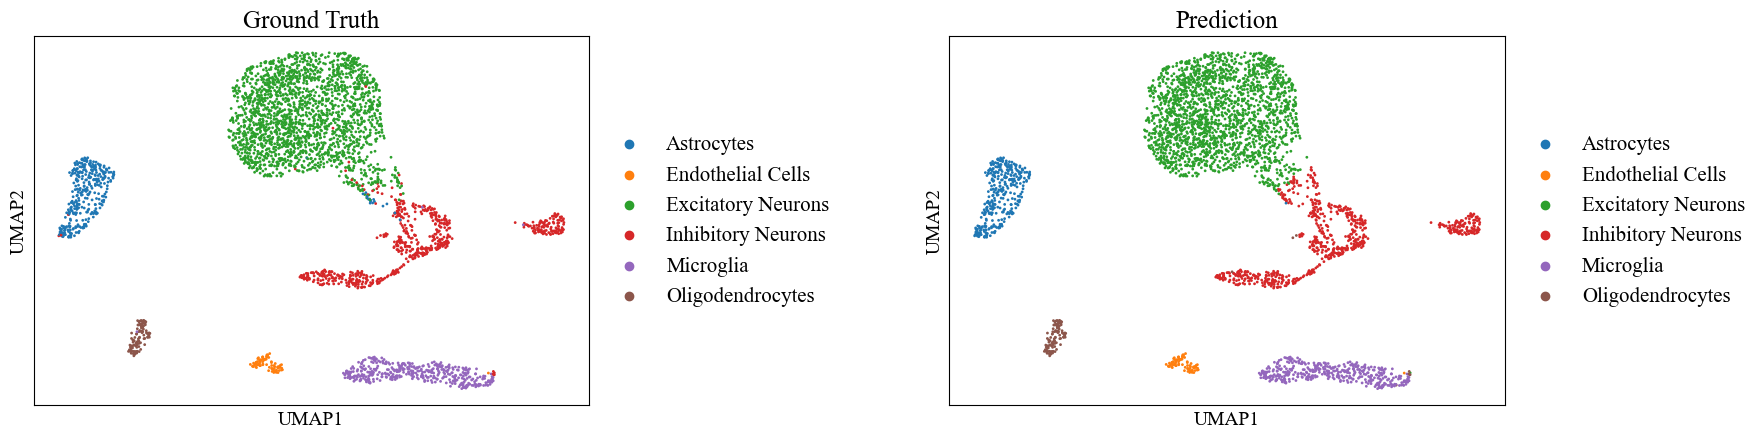

In [14]:
# Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 14  
plt.rcParams['axes.titlesize'] = 18  
plt.rcParams['axes.labelsize'] = 14  
plt.rcParams['xtick.labelsize'] = 12  
plt.rcParams['ytick.labelsize'] = 12  
plt.rcParams['legend.fontsize'] = 14  

adata = sc.read_h5ad("output/MosP1_MouseBrain(10x)/embedding.h5ad")
adata = adata[adata.obs["Batch"] == "MouseBrain(10x)"]

plt.figure(dpi=1200)

sc.pp.neighbors(adata, n_neighbors=25, use_rep='X', n_pcs=40)
sc.tl.umap(adata)

with plt.rc_context({'font.family': 'Times New Roman'}):
    sc.pl.umap(
        adata, 
        color=["CellType", "Pred"], 
        title=["Ground Truth", "Prediction"], 
        legend_fontsize=15,  
        legend_fontoutline=2,  
        frameon=True,  
        wspace=0.5,
        size=16,  
        # save="_MosP1_MouseBrain(10x)_GroundTruth_Pred.svg"
    )

#### Save Annotation and Ground Truth as a CSV file

In [15]:
# Save Annotation and Ground Truth as a CSV file
annotation = adata.obs["Pred"].values  # Predicted labels as Annotation
ground_truth = adata.obs['CellType'].values  # True labels as Ground_truth

# Create a DataFrame
df = pd.DataFrame({
    'true_label': ground_truth,
    'predicted_label': annotation
})

# Save to CSV
csv_path = os.path.join("output/MosP1_MouseBrain(10x)", "MosP1_MouseBrain(10x)_ref0_query1.csv")
df.to_csv(csv_path, index=False)

<Axes: >

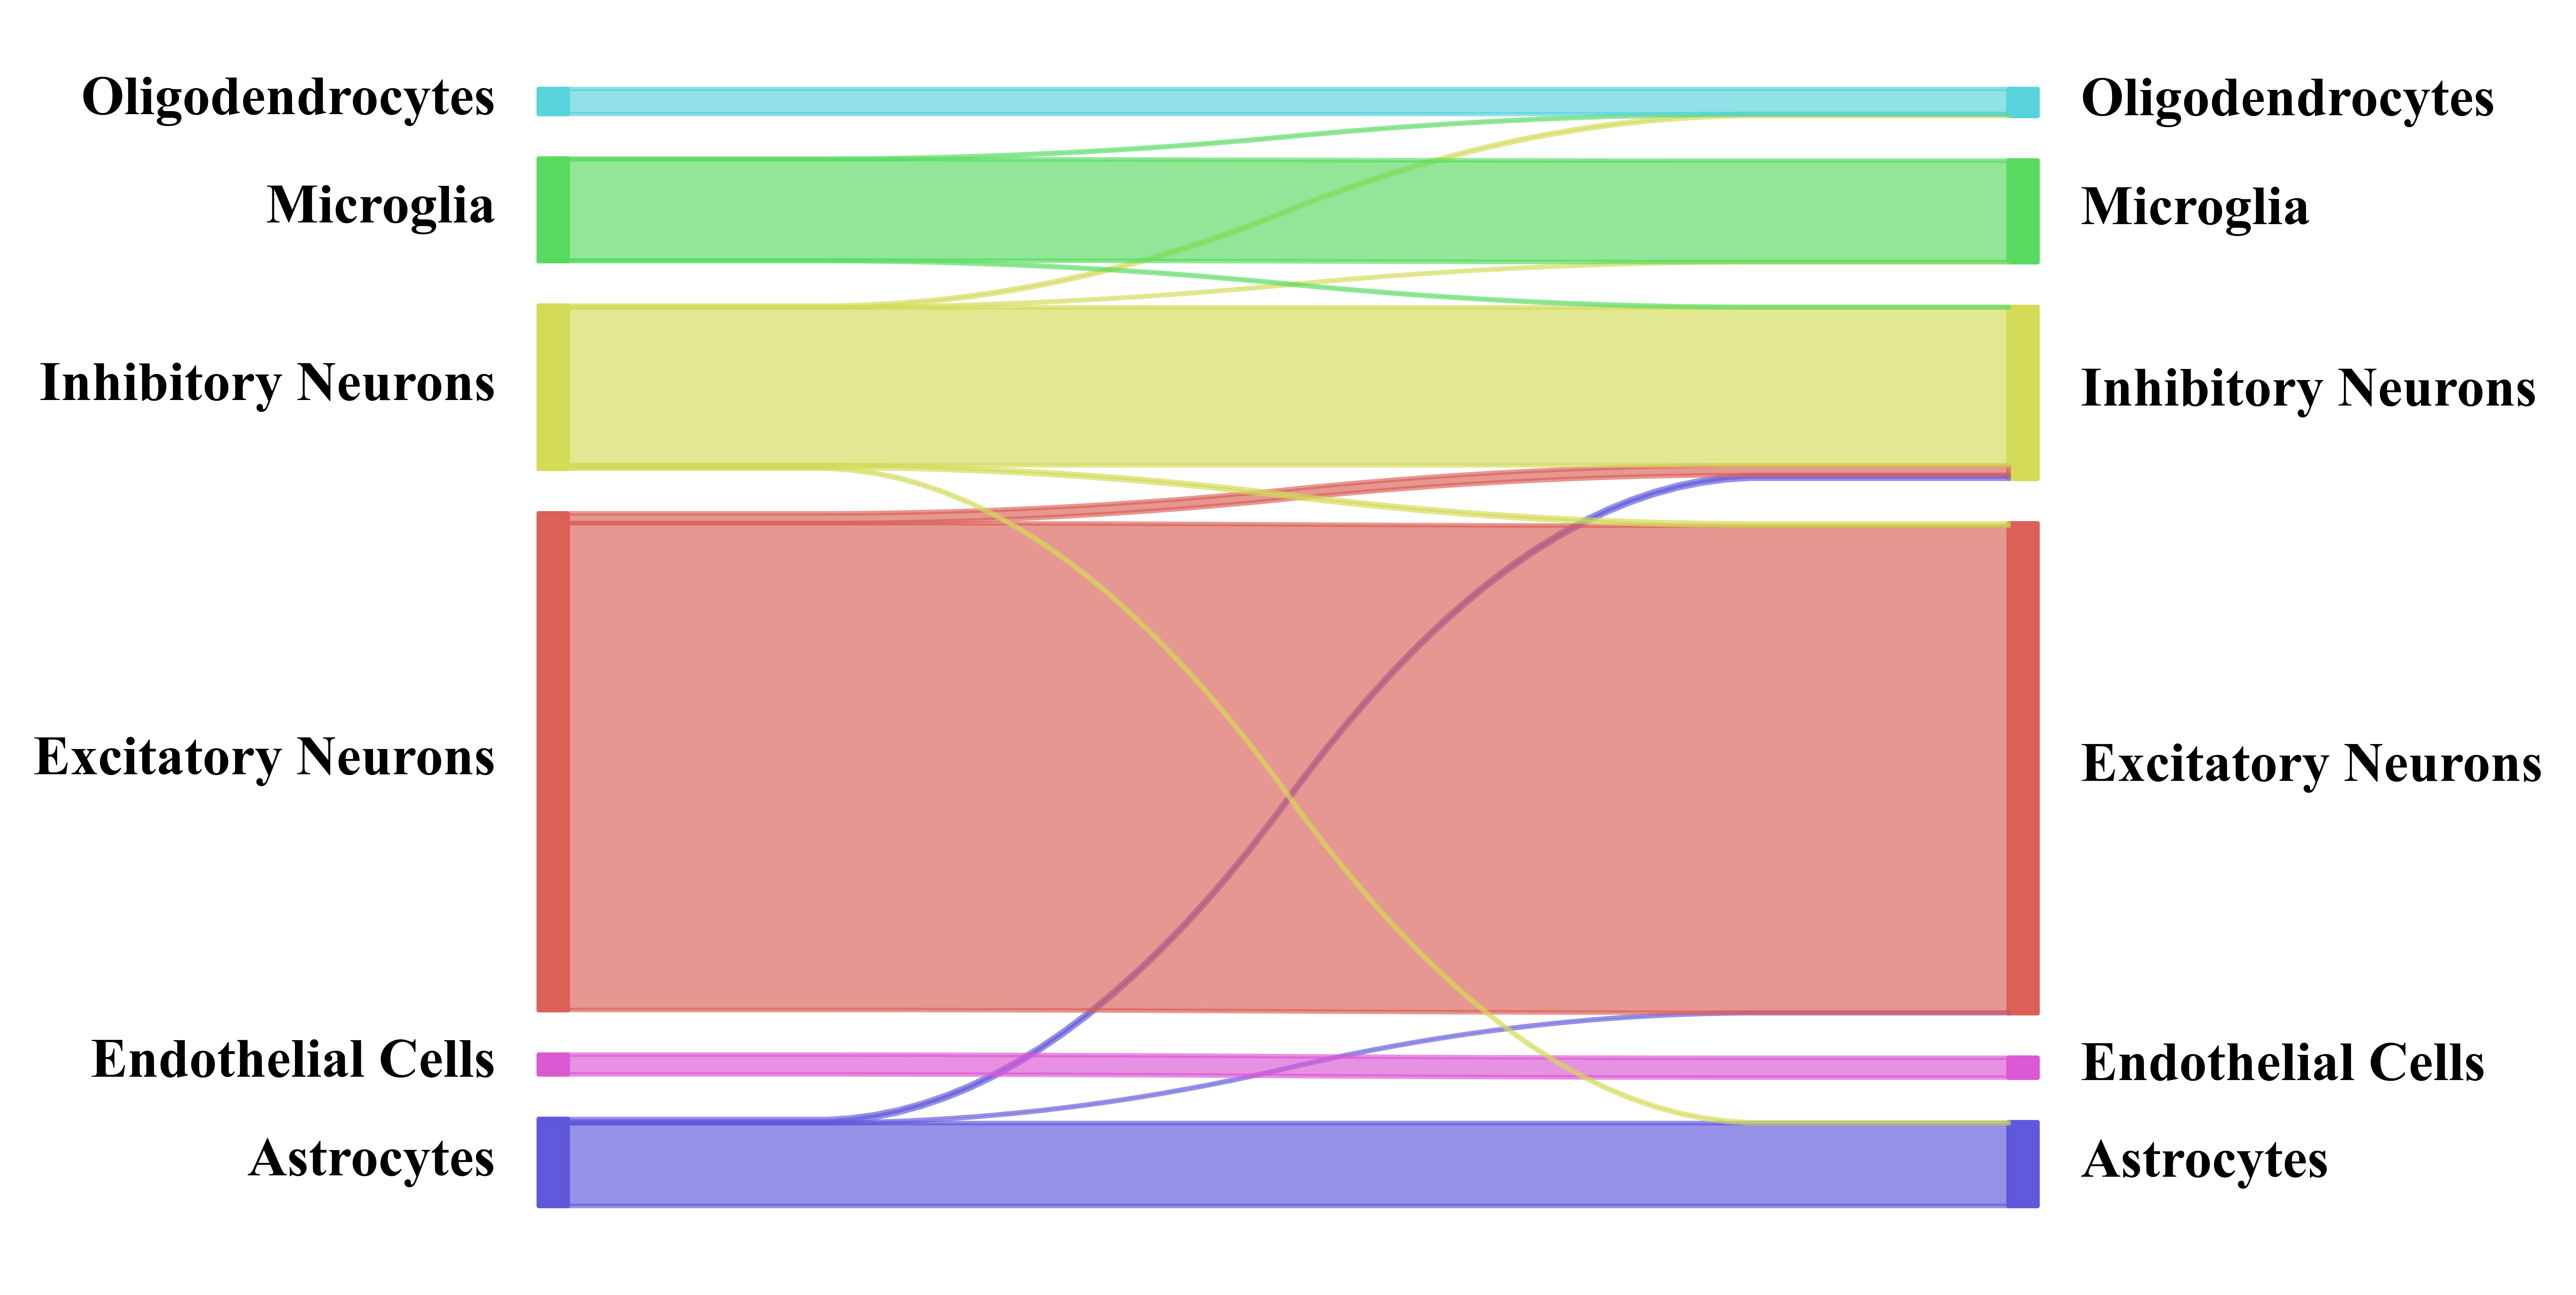

In [16]:
# from pySankey.sankey import sankey
import matplotlib.pyplot as plt
import numpy as np
from pysankey import sankey

plt.rcParams['font.family'] = 'Times New Roman'


pred_col = 'Pred'
true_col = 'CellType'

plt.rcParams['font.weight'] = "heavy"
plt.figure(dpi=1200)
sankey(
    adata.obs[true_col], adata.obs[pred_col], aspect=10,
    fontsize=12, leftLabels = list(np.unique(adata.obs[true_col])), rightLabels = list(np.unique(adata.obs[pred_col]))
    )
# plt.savefig("output/MosP1_MouseBrain(10x)_GroundTruth_Pred.svg", bbox_inches="tight")